In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from codecarbon import track_emissions, EmissionsTracker
from typing import List, Tuple, Dict, Optional

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer

import warnings

warnings.filterwarnings("ignore")

np.random.seed(415915)

# Enoncé

Le but de ce TP va être de mesurer la consommation carbone du code que vous allez créer et de toutes les manipulations de données que vous allez effecuer. 
Pour cela, nous allons utiliser la librairie code carbon qui va chercher la consommation de votre CPU pour la traduire en émission carbone. Pour faire appel à cette librairie, voilà deux snippets de code qui vous le permettent: 

In [8]:
# tracker = EmissionsTracker()
# tracker.start()
# """ insert your code here """
# emissions: float = tracker.stop()


# @track_emissions(project_name='project_to_track')
# def function_to_track():
#     return """ Insert your code here """

# Feature engineering 
A partir de maintenant, nous vous proposons de partir dans de l'exploration des données chargées ci-dessous. 
Vous trouverez dans la classe CustomFeature, des fonctions vous permettant rapidement de visualiser certaines données, ainsi que le nombre de modalités pour chaque variable catégorielle. Libre à vous d'orienter votre feature engineering vers la méthode qui vous semble la plus adéquate. 

A nouveau dans la classe CustomFeature, deux méthodes ont été pré-construites vous permettant l'imputation de valeurs manquantes.   
 - Soit à travers une stratégie classique grâce au SimpleImputer
 - Soit au travers de l'algorithme des plus proches voisins avec un KNNImputer. 

Quelques pistes pour vous aiguiller : 
    Le jeu en vaut-il toujours la chandelle ? 
    Est-ce que plus compliqué veut toujours dire meilleur ? 
    Est-ce que plus simple satisfait quand même les besoins métiers ? 


Commentaire pour équipe GreenAI: 
la target est normalement le C02, j'ai volontairement modifié celle-ci pour que l'on puisse ingégrer de l'oversampling dans la pipeline de modélisation + les résultats étaient déjà "trop" bons sans fine tuning. On passerait donc d'un pb de regression à un pb de classification multi-classe en tentant de prédire le type de carrosserie de voiture (ie Monospace, Minibus, coupé, break.. )



# Modelisation 

Vous avez maintenant terminé votre feature engineering, ou du moins entamé une première version. Vous aviez des convictions sur la performance de certaines méthodes de Data Science, ous avez maintenant développé quelques convictions sur les émissions de celles-ci. 

Pour aller plus loin, appliquons les questions que nous nous sommes posées dans la partie Feature Engineering et tentons d'en tirer des conclusions sur le choix de modèle à utiliser, et sur la manière de l'entraîner. 

Deux algorithmes de l'état de l'art vous sont proposés, à savoir la régression logistique et le LightGBM, tous deux assez reputés pour leur faible consommation. 

Nous vous proposons de commencer par tenter des simulations d'entraînement à partir de ces deux modèles pour ensuite tester un ou deux modèles réputés plus performants mais aussi plus gourmands en ressources (@Camille c'est ici qu'on peut inclure ton MLP et RF avec tes scatterplot je pense! )

@Theophile on peut rajouter ici une note pour préciser qu'on reste sur des modèles disponibles depuis scikit-learn pour éviter que tout le monde puisse installer des librairies ? 


In [9]:
df = pd.read_csv("../data/mars-2014-complete.csv", sep=";", encoding="latin-1")

lexique = pd.read_excel("../data/carlab-annuaire-variable.xlsx")

In [10]:
# from codecarbon import EmissionsTracker
# tracker = EmissionsTracker()
# tracker.start()
# """ insert your code here """
# emissions: float = tracker.stop()


# @track_emissions(project_name='project_to_track')
# def function_to_track():
#     return """ Insert your code here """

# @ALL 

je prends vos retours sur: 
 1-  est-ce qu'on a trop de fonctions ? 
 2-  améliorer le code
 3- quelles fonctions on laisse comme telles, lesquelles où on fournit juste la méthode pour que les gens puissent expérimenter de leur côté

NB: je compte commenter toute les fonctions pour perdre personne 

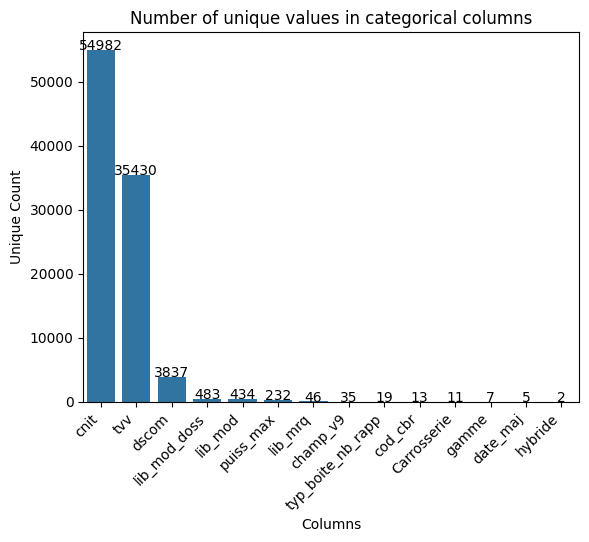

Beginning imputation...
Imputation complete, doing last steps...


In [11]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()


class CustomFeature:
    """
    This class provides custom feature engineering functions for data preprocessing.
    """

    def __init__(self):
        """
        Initializes the CustomFeature object.
        """
        self.map_hybrid = {"non": 0.0, "oui": 1.0}
        self.map_carrosserie = {
            "MINIBUS": 0,
            "BERLINE": 1,
            "BREAK": 2,
            "TS TERRAINS/CHEMINS": 3,
            "COUPE": 4,
            "MONOSPACE": 5,
            "CABRIOLET": 6,
        }

    def plot_bar(self, data: pd.DataFrame) -> None:
        """
        Plots a bar chart showing the number of unique values in categorical columns.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            None
        """
        ax = sns.barplot(x="Column", y="Modalité", data=data)
        plt.title("Number of unique values in categorical columns")
        plt.xlabel("Columns")
        plt.ylabel("Unique Count")
        plt.xticks(rotation=45, ha="right")
        for index, row in data.iterrows():
            ax.text(index, row["Modalité"], row["Modalité"], ha="center")
        plt.show()

    def countplot_categorical_ftr(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Counts the number of unique values in categorical columns and plots a bar chart.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: A DataFrame containing the column names and their corresponding unique counts.
        """
        counts = []
        for column in data.columns:
            if not pd.api.types.is_numeric_dtype(data[column]):
                unique_count = data[column].nunique()
                counts.append((column, unique_count))
        counts_df = (
            pd.DataFrame(counts, columns=["Column", "Modalité"])
            .sort_values(by="Modalité", ascending=False)
            .reset_index()
        )
        self.plot_bar(counts_df)
        return counts_df

    def get_number_of_ch(self, data: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Extracts the number of 'ch' from a text column and adds it as a new column 'CH' in the DataFrame.

        Args:
            data (pd.DataFrame): The input data.
            column (str): The name of the column containing the text.

        Returns:
            pd.DataFrame: The updated DataFrame with the new 'CH' column.
        """
        pattern = r"(\d+)\s*ch"
        data["CH"] = [
            re.findall(pattern, text)[0] if re.findall(pattern, text) else None
            for text in data[column]
        ]
        return data

    def get_norme_euro(self, data: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Extracts the 'NORME_EURO' from a text column and adds it as a new column in the DataFrame.

        Args:
            data (pd.DataFrame): The input data.
            column (str): The name of the column containing the text.

        Returns:
            pd.DataFrame: The updated DataFrame with the new 'NORME_EURO' column.
        """
        tmp_champv9 = data[column].fillna(value="")
        data["NORME_EURO"] = [
            text[-5:] if "EURO" in text else None for text in tmp_champv9
        ]
        replace_euros = [None, "2EURO"]
        df["NORME_EURO"] = data["NORME_EURO"].replace(replace_euros, "MANQUANT")
        return data

    def encode_hybride_col(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Encodes the 'hybride' column using a predefined mapping.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the encoded 'hybride' column.
        """
        data["hybride"] = data["hybride"].map(self.map_hybrid)
        return data

    def build_target_col(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Builds the 'TARGET' column based on the 'Carrosserie' column using a predefined mapping.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the 'TARGET' column.
        """
        values_to_replace = [
            "MONOSPACE COMPACT",
            "COMBISPACE",
            "MONOSPACE",
            "COMBISPCACE",
            "MINISPACE",
        ]
        data["Carrosserie"] = data["Carrosserie"].replace(
            values_to_replace, "MONOSPACE"
        )
        data["TARGET"] = data["Carrosserie"].map(self.map_carrosserie)
        data.drop("Carrosserie", axis=1, inplace=True)
        return data

    def knn_impute(
        self, n_neighbors: int, data: pd.DataFrame, cols_to_impute: List[str]
    ) -> pd.DataFrame:
        """
        Performs KNN imputation on the specified columns.

        Args:
            n_neighbors (int): The number of neighbors to consider for imputation.
            data (pd.DataFrame): The input data.
            cols_to_impute (list): A list of column names to impute.

        Returns:
            pd.DataFrame: The updated DataFrame with the imputed values.
        """
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_values = imputer.fit_transform(df[cols_to_impute])
        for i in range(len(cols_to_impute)):
            data[f"imputed_{cols_to_impute[i]}"] = [
                imputed_values[k][i] for k in range(len(imputed_values))
            ]
        data.drop(cols_to_impute, axis=1, inplace=True)
        return data

    def easy_impute(self, data: pd.DataFrame, strategy: str, cols_to_impute):
        """
        Performs simple imputation on the specified columns using the specified strategy.

        Args:
            data (pd.DataFrame): The input data.
            strategy (str): The imputation strategy to use.
            cols_to_impute (list): A list of column names to impute.

        Returns:
            pd.DataFrame: The updated DataFrame with the imputed values.
        """
        imputer = SimpleImputer(strategy=strategy)
        for col in cols_to_impute:
            data[col] = imputer.fit_transform(data[[col]])
        return data

    def drop_unused_cols(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Drops unused columns from the DataFrame.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the unused columns dropped.
        """
        data.drop(
            [
                "hc",
                "date_maj",
                "lib_mrq",
                "lib_mod_doss",
                "lib_mod",
                "dscom",
                "cnit",
                "tvv",
                "champ_v9",
            ],
            axis=1,
            inplace=True,
        )
        data.drop(["CH", "typ_boite_nb_rapp"], axis=1, inplace=True)
        data.drop(["conso_exurb", "conso_mixte"], axis=1, inplace=True)
        data.drop("cod_cbr", axis=1, inplace=True)
        return data

    def encode_col(self, data: pd.DataFrame, col: str) -> pd.DataFrame:
        """
        Encodes a categorical column using one-hot encoding.

        Args:
            data (pd.DataFrame): The input data.
            col (str): The name of the column to encode.

        Returns:
            pd.DataFrame: The updated DataFrame with the encoded column.
        """
        dummies = pd.get_dummies(data[col], prefix=col, dtype=int, drop_first=True)
        data = data.join(dummies)
        df["is_GO"] = df["cod_cbr"].apply(lambda x: 1 if x == "GO" else 0)
        return data


simulation = CustomFeature()

simulation.countplot_categorical_ftr(
    df
)  # Countplot of unique values in categorical columns
df = simulation.get_number_of_ch(df, "dscom")  # Extract number of 'ch' from text column
df = simulation.get_norme_euro(df, "champ_v9")  # Extract 'NORME_EURO' from text column
df = simulation.encode_hybride_col(df)  # Encode 'hybride' column
impute_cols = [
    "conso_urb",
    "co2",
    "co_typ_1",
    "hcnox",
    "ptcl",
    "nox",
]  # Columns to impute
print("Beginning imputation...")
df_imputed = simulation.knn_impute(
    n_neighbors=2, data=df, cols_to_impute=impute_cols
)  # KNN imputation
print("Imputation complete, doing last steps...")
df_imputed = simulation.encode_col(df_imputed, "gamme")  # One-hot encoding
df_imputed = simulation.drop_unused_cols(df_imputed)  # Drop unused columns
df_imputed = simulation.build_target_col(df_imputed)  # Build target column
impute_emissions = tracker.stop()  # Stop tracking emissions

In [12]:
df_imputed["puiss_max"] = [float(x.replace(",", ".")) for x in df_imputed["puiss_max"]]

In [13]:
grouped = df.groupby("Carrosserie")["imputed_co2"].median()
grouped.plot(kind="bar")
plt.xlabel("Carrosserie")
plt.ylabel("CO2")
plt.title("Average CO2 Emissions by Carrosserie")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Carrosserie", y="imputed_co2", palette="Set1", s=100)
plt.xlabel("Row Index")
plt.ylabel("CO2 Emissions")
plt.title("CO2 Emissions by Carrosserie")
plt.legend(title="Carrosserie")
plt.tight_layout()

plt.figure(figsize=(10, 6))
df["hcnox100"] = [1000 * x for x in df["imputed_hcnox"]]
sns.scatterplot(
    data=df, x="hcnox100", y="imputed_co2", hue="Carrosserie", palette="Set1", s=75
)
plt.xlabel("Hcnox * 100")
plt.ylabel("CO2 Emissions")
plt.title("CO2 Emissions by Carrosserie")
plt.legend(title="Carrosserie")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


@Camille libre à toi de modifier la structure de la classe
j'ai créé une méthode random_search_CV() pour créer le corps de la fonction
je pense qu'on peut rajouter aussi une fonction qui comme dans ton notebook, va aller chercher tous nos modèles et établir un graph sur les perfs en tests vs sur la consommation globale training+inférence 

@All, des retours ? 

In [14]:
class Model:
    def __init__(self) -> None:
        """
        Initialize the Model class.

        This class represents a machine learning model.

        Attributes:
        - name: The name of the model.
        - model: The machine learning model object.
        - train_emissions: The emissions during training.
        - grid_emissions: The emissions during grid search cross validation.
        - random_emissions: The emissions during random search cross validation.
        - params_grid: The grid of hyperparameters for grid search.

        """
        self.name = ""
        self.model = None
        self.train_emissions = None
        self.grid_emissions = None
        self.random_emissions = None
        self.params_grid = None

    def grid_search_CV(
        self, nb_fold: int, X: pd.DataFrame, y: pd.Series, scoring: Optional[str] = None
    ) -> None:
        """
        Perform a grid search cross validation on the model.

        Args:
        - nb_fold: The number of folds for cross validation.
        - X: The input features.
        - y: The target variable.
        - scoring: The scoring metric for evaluation.

        """
        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        grid_search = GridSearchCV(
            self.model, self.params_grid, cv=nb_fold, scoring=scoring
        )
        print("Beginning grid search...")
        tracker.start()
        grid_search.fit(X, y)
        self.grid_emissions = tracker.stop() * 1000
        self.grid_search = grid_search
        print("Grid search complete")

    def random_search_CV(
        self,
        nb_iter: int,
        nb_fold: int,
        X: pd.DataFrame,
        y: pd.Series,
        scoring: Optional[str] = None,
    ) -> None:
        """
        Perform a random search cross validation on the model.

        Args:
        - nb_iter: The number of iterations for random search.
        - nb_fold: The number of folds for cross validation.
        - X: The input features.
        - y: The target variable.
        - scoring: The scoring metric for evaluation.

        """
        print("Beginning random search...")
        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        random_search = RandomizedSearchCV(
            self.model, self.params_grid, n_iter=nb_iter, cv=nb_fold, scoring=scoring
        )
        tracker.start()
        random_search.fit(X, y)
        self.random_emissions = tracker.stop() * 1000
        self.random_search = random_search
        print("Random search complete")

    def train(self, X: pd.DataFrame, y: pd.Series, params: Optional[Dict] = None):
        """
        Train the model on the data.

        Args:
        - X: The input features.
        - y: The target variable.
        - params: Optional dictionary of hyperparameters.

        """
        if params is not None:
            self.model = self.model.set_params(params)
        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()
        self.model.fit(X, y)
        self.train_emissions = tracker.stop() * 1000

    def predict(self, X: pd.DataFrame) -> np.array:
        """
        Predict the target variable.

        Args:
        - X: The input features.

        Returns:
        - np.array: The predicted target variable.

        """
        return self.model.predict(X)


class LRModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "LR"
        self.model = LogisticRegression()
        self.params_grid = {
            "C": [0.001, 0.01, 0.1, 1, 10],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"],
        }


class RFModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "RF"
        self.model = RandomForestClassifier()
        self.params_grid = {
            "n_estimators": [100],
            "max_depth": [10],
            "min_samples_split": [2, 5, 10],
        }


class LGBMModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "LGBM"
        self.model = LGBMClassifier()
        self.params_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30, 40],
            "learning_rate": [0.1, 0.01],
        }


class GBModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "GB"
        self.model = GradientBoostingClassifier()
        self.params_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30],
            "learning_rate": [0.1, 0.01, 0.001],
        }


class SVRModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "SVR"
        self.model = SVC()
        self.params_grid = {
            "C": [0.001, 0.01, 0.1, 10],
            "gamma": [0.001, 0.01, 0.1, 1],
            "kernel": ["linear", "sigmoid"],
        }


class MLPModel(Model):
    def __init__(self) -> None:
        super().__init__()
        self.name = "MLP"
        self.model = MLPClassifier()
        self.params_grid = {
            "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100,)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
            "alpha": [0.001, 0.05],
            "learning_rate": ["constant", "adaptive"],
        }


def evaluate(
    model: sklearn.base.BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    scoring_method: str = "accuracy",
) -> tuple[float, float]:
    """Evaluate the model on the data.

    Parameters:
    - model (sklearn.base.BaseEstimator): The trained model to evaluate.
    - X (pd.DataFrame): The input features for evaluation.
    - y (pd.Series): The target variable for evaluation.
    - scoring_method (str, optional): The scoring method to use for evaluation. Default is 'accuracy'.

    Returns:
    - tuple[float, float]: A tuple containing the evaluation score and the emissions in milliseconds.

    Raises:
    - ValueError: If an invalid scoring method is provided.

    """
    tracker = EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()
    if scoring_method == "accuracy":
        score = accuracy_score(y, model.predict(X))
        emissions = tracker.stop() * 1000
    elif scoring_method == "f1_score":
        score = f1_score(y, model.predict(X), average="weighted")
        emissions = tracker.stop() * 1000
    elif scoring_method == "r2_score":
        score = r2_score(y, model.predict(X))
        emissions = tracker.stop() * 1000
    else:
        raise ValueError(
            "Invalid scoring method, please choose between r2_score and f1_score"
        )
    return score, emissions

In [15]:
# train test split
X = df_imputed.drop(["TARGET", "gamme", "NORME_EURO"], axis=1)
y = df_imputed["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2ème partie : Sélection du modèle

### Ici, vous allez pouvoir comparer différents modèles en fonction de leurs performances mais aussi et ce qui nous intéresse vraiment aujourd'hui : leur consommation lors du training ainsi que de l'inférence


#### NB : On ne se soucis pour l'instant pas des hyper-paramètres

## 2.1 Training

In [16]:
models_to_test = [
    LRModel(),
    RFModel(),
    LGBMModel(),
    GBModel(),
    SVRModel(),
    MLPModel(),
]  # type: List[Model] # Peut-être laisser vide pour que les gens testent les modèles qu'ils veulent
models_names = [model.name for model in models_to_test]  # type: List[str]

In [17]:
# loop over models
for model in models_to_test:
    model.train(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 44035, number of used features: 17
[LightGBM] [Info] Start training from score -0.175852
[LightGBM] [Info] Start training from score -2.528514
[LightGBM] [Info] Start training from score -3.804168
[LightGBM] [Info] Start training from score -3.931167
[LightGBM] [Info] Start training from score -4.156048
[LightGBM] [Info] Start training from score -4.256590
[LightGBM] [Info] Start training from score -4.631283


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


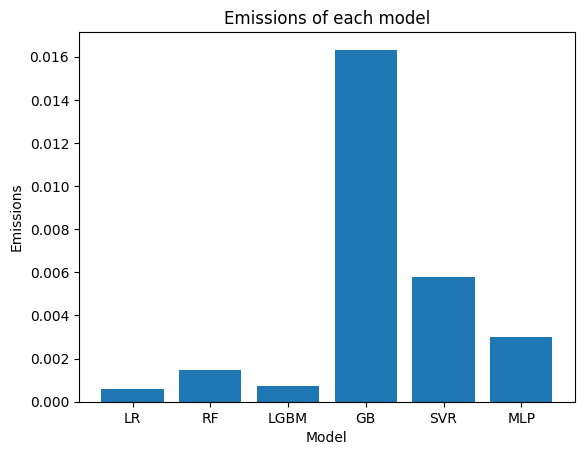

In [18]:
# barplot of emissions
emissions = [model.train_emissions for model in models_to_test]  # type : List[float]
plt.bar(models_names, emissions)
plt.xlabel("Model")
plt.ylabel("Emissions")
plt.title("Emissions of each model")
plt.show()

## 2.2 Inference

In [19]:
models_scores = []  # type: List[float]
models_emissions = []  # type: List[float]

for model in models_to_test:
    score, emissions = evaluate(model.model, X_test, y_test)
    models_scores.append(score)
    models_emissions.append(emissions)

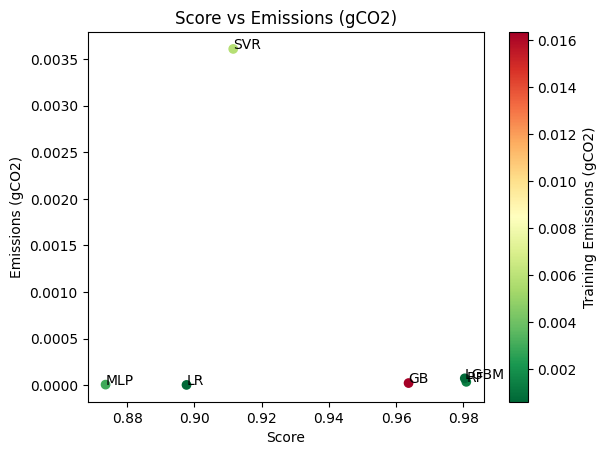

In [20]:
# scatter plot scores vs emissions with color representing the training emissions
plt.scatter(
    models_scores,
    models_emissions,
    c=[model.train_emissions for model in models_to_test],
    cmap="RdYlGn_r",
)
for i, model in enumerate(models_names):
    plt.annotate(model, (models_scores[i], models_emissions[i]))
plt.xlabel("Score")
plt.ylabel("Emissions (gCO2)")
plt.title("Score vs Emissions (gCO2)")
plt.colorbar(label="Training Emissions (gCO2)")
plt.show()

# Partie 3 : Hyper-parameter tuning Green vs Red

### Dans cette partie nous allons comparer deux méthodes d'HP Tuning : GridSearch, de loin la plus utilisées et enfin RandomSearch qui est tout aussi facilement implémentable.

In [21]:
model_chosen = models_to_test[
    1
]  # type: Model # Laisser le choix à l'utilisateur du modèle qu'il veut tester

print("Model : ", model_chosen.name)

model_chosen.random_search_CV(nb_iter=10, nb_fold=5, X=X_train, y=y_train)

model_chosen.grid_search_CV(nb_fold=5, X=X_train, y=y_train)

Model :  RF
Beginning random search...


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


Random search complete
Beginning grid search...


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


Grid search complete


ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


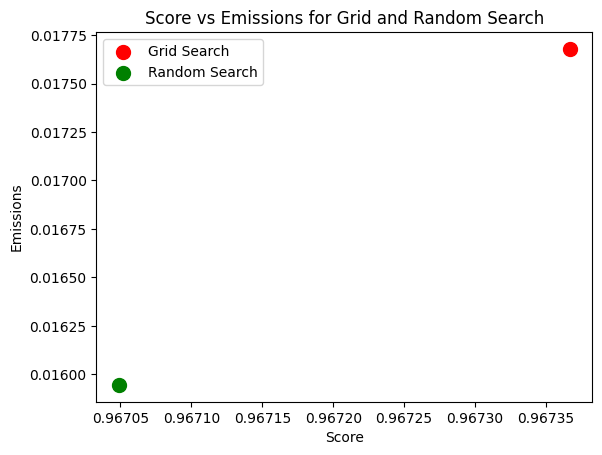

In [23]:
# small scatter plot of the emissions of the different search scores / emissions
plt.scatter(
    model_chosen.grid_search.best_score_,
    model_chosen.grid_emissions,
    label="Grid Search",
    c="red",
    s=100,
)
plt.scatter(
    model_chosen.random_search.best_score_,
    model_chosen.random_emissions,
    label="Random Search",
    c="green",
    s=100,
)
plt.xlabel("Score")
plt.ylabel("Emissions")
plt.title("Score vs Emissions for Grid and Random Search")
plt.legend()